In [1]:
import pandas as pd
import numpy as np
import altair as alt
alt.data_transformers.enable('json')
import datetime as dt
from sublimpy import utils
import pytz

In [2]:
df = pd.read_csv("~/Development/data/sublimationofsnow/mott2018_table1_data.csv")

In [3]:
alt.Chart(df).transform_fold(
    ['Surface', 'Blowing']
).mark_point().encode(
    alt.X("value:Q").title("% winter snowfall lost to sublimation"),
    alt.Y("key:N").title(None)
).properties(

).display(renderer='svg')

alt.Chart(...)

# Open SOS Measurement Dataset

In [2]:
start_date = '20221130'
end_date = '20230509'
# open files
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')

In [3]:
tidy_df = utils.modify_df_timezone(
    tidy_df,
    pytz.UTC,
    'US/Mountain',   
)
tidy_df = tidy_df.set_index('time').sort_index().loc['20221130':'20230508'].reset_index()

In [4]:
# quick way to get variable info if we want it 
# import xarray as xr
# ds = xr.open_dataset("/storage/elilouis/sublimationofsnow/sosnoqc/isfs_20221228.nc")
# ds['SWE_p2_c']

# Make plot showing cumulative sublimation

In [5]:
seconds_in_timestep = 60*30
from metpy.constants import density_water

In [6]:
measured_results_mm = tidy_df[tidy_df.variable.isin([
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',

    'w_h2o__3m_ue',
    'w_h2o__10m_ue',

    'w_h2o__3m_uw',
    'w_h2o__10m_uw',

    'w_h2o__3m_d',
    'w_h2o__10m_d',
])][
    ['time', 'value', 'variable']
]
measured_results_mm.columns = ['time', 'measured', 'variable']
measured_results_mm = measured_results_mm.pivot(
    index = 'time',
    columns = 'variable',
    values = 'measured'
)
# convert to mm
measured_results_mm = measured_results_mm*seconds_in_timestep/density_water.magnitude
measured_results_cumsum = measured_results_mm.cumsum().reset_index()
measured_results_cumsum = measured_results_cumsum.melt(id_vars='time')
measured_results_cumsum['height'] = measured_results_cumsum['variable'].apply(lambda s: int(s.split('__')[1].split('m')[0]))
measured_results_cumsum['tower'] = measured_results_cumsum['variable'].apply(lambda s: s.split('__')[1].split('_')[-1])
measured_results_cumsum['tower-height'] = measured_results_cumsum['tower'] + '-' + measured_results_cumsum['height'].astype('str')
measured_results_cumsum


measured_results_cumsum

,time,variable,value,height,tower,tower-height
0,2022-11-30 00:00:00,w_h2o__10m_c,0.001965,10,c,c-10
1,2022-11-30 00:30:00,w_h2o__10m_c,0.002816,10,c,c-10
2,2022-11-30 01:00:00,w_h2o__10m_c,0.001704,10,c,c-10
3,2022-11-30 01:30:00,w_h2o__10m_c,0.002368,10,c,c-10
4,2022-11-30 02:00:00,w_h2o__10m_c,0.001726,10,c,c-10
...,...,...,...,...,...,...
92131,2023-05-08 21:30:00,w_h2o__5m_c,37.923199,5,c,c-5
92132,2023-05-08 22:00:00,w_h2o__5m_c,37.921184,5,c,c-5
92133,2023-05-08 22:30:00,w_h2o__5m_c,37.928547,5,c,c-5
92134,2023-05-08 23:00:00,w_h2o__5m_c,37.928721,5,c,c-5


In [7]:
rnet_chart = alt.Chart(
    tidy_df.query("variable == 'Rnet_9m_d'")
).transform_window(
    frame = [-12, 12],
    rolling_mean = 'mean(value)'
).mark_line(opacity=0.5).encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("rolling_mean:Q").title(["Net radiation", "(W/m^2)"])
)
rnet_chart

alt.Chart(...)

In [8]:
snowpillow_chart = alt.Chart(
    tidy_df.query("variable == 'SWE_p2_c'").dropna()
).transform_window(
    frame = [-48, 48],
    rolling_median = 'median(value)'
).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("rolling_median:Q").title(["Snow water", "equivalent (mm)"])
).properties(height = 83)
snowpillow_chart

alt.Chart(...)

In [9]:
cum_sub_and_snowpack_swe_chart = (
snowpillow_chart &\
alt.Chart(measured_results_cumsum.dropna()).transform_filter(
    alt.datum.height > 1
).mark_line(strokeWidth=1.5).transform_window(
    rolling_median = "median(value)",
    groupby = ["height", "tower-height"],
    frame=[-2,2]
).encode(
    alt.X("time:T"),
    alt.Y("rolling_median:Q").title("Cumulative sublimation (mm)"),
    alt.Color("height:O").scale(scheme = 'turbo'),
    detail = "tower-height"
)
).resolve_scale(
    x='shared', y='independent', color='independent'
)

cum_sub_and_snowpack_swe_chart.save("cum-sub-and-snowpack-swe.png", ppi=200)
cum_sub_and_snowpack_swe_chart

alt.VConcatChart(...)

In [10]:
alt.Chart(measured_results_cumsum.dropna()).transform_filter(
    alt.datum.height > 1
).mark_line(strokeWidth=1.5).transform_window(
    rolling_median = "median(value)",
    groupby = ["height", "tower-height"],
    frame=[-2,2]
).encode(
    alt.X("time:T"),
    alt.Y("rolling_median:Q").title("Cumulative sublimation (mm)"),
    alt.Color("height:O").scale(scheme = 'turbo'),
    detail = "tower-height"
).properties(width=1000).interactive()

alt.Chart(...)

In [11]:
src = tidy_df[tidy_df.measurement == 'w_h2o_'][~tidy_df.variable.str.contains("predicted")].query("height > 2.5")
src = src[src.time >= '2022-12-31 00:00:00'][src.time < '2023-01-01 2300']
alt.Chart(src).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("variable:N")
).interactive()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77866/1516847227.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src = tidy_df[tidy_df.measurement == 'w_h2o_'][~tidy_df.variable.str.contains("predicted")].query("height > 2.5")
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77866/1516847227.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src = src[src.time >= '2022-12-31 00:00:00'][src.time < '2023-01-01 2300']


alt.Chart(...)

In [12]:
src = tidy_df[tidy_df.measurement == 'w_w_'].query("tower == 'c'")
src = src[src.time >= '2023-02-27 00:00:00'][src.time < '2023-02-27 18:00:00']
alt.Chart(src).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N")
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77866/3032159401.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src = src[src.time >= '2023-02-27 00:00:00'][src.time < '2023-02-27 18:00:00']


alt.Chart(...)

In [13]:
src_lhflux = tidy_df[tidy_df.measurement == 'w_h2o_'][~tidy_df.variable.str.contains("predicted")]
src_lhflux = src_lhflux[src_lhflux.time > '2023-03-07 0900'][src_lhflux.time < '2023-03-07 1500']

src_bsflux = tidy_df[tidy_df.measurement == 'snow flux']
src_bsflux = src_bsflux[src_bsflux.time > '2023-03-07 0900'][src_bsflux.time < '2023-03-07 1500']

src_flags = tidy_df[tidy_df.measurement.isin([
    "sonic anemometer diagnostic flag",
    "irgason diagnostic flag"
])]
src_flags = src_flags[src_flags.time > '2023-03-07 0900'][src_flags.time < '2023-03-07 1500']

src_temp = tidy_df[tidy_df.measurement.isin([
    "temperature"
])]
src_temp = src_temp[src_temp.time > '2023-03-07 0900'][src_temp.time < '2023-03-07 1500']

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77866/803677439.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src_lhflux = tidy_df[tidy_df.measurement == 'w_h2o_'][~tidy_df.variable.str.contains("predicted")]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77866/803677439.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src_lhflux = src_lhflux[src_lhflux.time > '2023-03-07 0900'][src_lhflux.time < '2023-03-07 1500']
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77866/803677439.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src_bsflux = src_bsflux[src_bsflux.time > '2023-03-07 0900'][src_bsflux.time < '2023-03-07 1500']
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77866/803677439.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src_flags = src_flags[src_flags.time > '2023-03-07 0900'][src_flags.

In [14]:
alt.Chart(src_temp.query("height != 3").query("height != 1")).mark_line().encode(
    alt.X("value:Q").title("temperature (˚C)").sort('-y'),
    alt.Y("height:Q"),
    alt.Facet("time:T", columns=5).header(format='%H:%M')
).properties(width = 150, height = 150)

alt.Chart(...)

In [15]:
(
alt.Chart(src_bsflux).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
).properties(width = 800, height = 150)
&
alt.Chart(src_lhflux).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
).properties(width = 800, height = 150)
&
alt.Chart(src_flags).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    alt.Row("measurement:N"),
    detail='variable'
).properties(width = 800, height = 150)
).resolve_scale(color='independent')

alt.VConcatChart(...)

In [16]:
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset(
    "~/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20230307.nc"
)

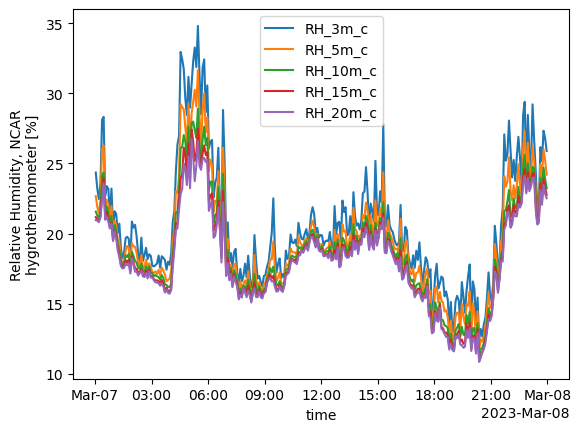

In [17]:
ds['RH_3m_c'].plot(label = 'RH_3m_c')
ds['RH_5m_c'].plot(label = 'RH_5m_c')
ds['RH_10m_c'].plot(label = 'RH_10m_c')
ds['RH_15m_c'].plot(label = 'RH_15m_c')
ds['RH_20m_c'].plot(label = 'RH_20m_c')
plt.legend()

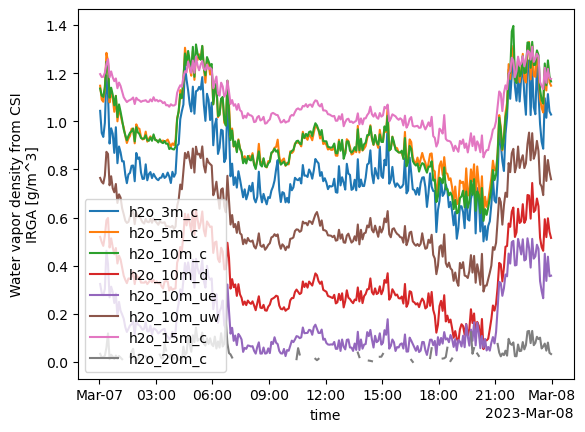

In [18]:
ds['h2o_3m_c'].plot(label='h2o_3m_c')
ds['h2o_5m_c'].plot(label='h2o_5m_c')
ds['h2o_10m_c'].plot(label='h2o_10m_c')
ds['h2o_10m_d'].plot(label='h2o_10m_d')
ds['h2o_10m_ue'].plot(label='h2o_10m_ue')
ds['h2o_10m_uw'].plot(label='h2o_10m_uw')
ds['h2o_15m_c'].plot(label='h2o_15m_c')
ds['h2o_20m_c'].plot(label='h2o_20m_c')
plt.legend()

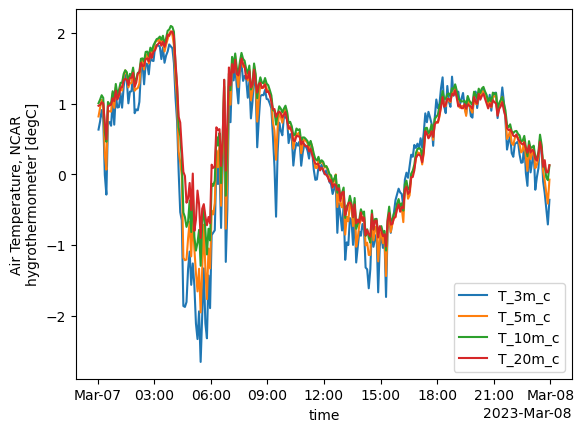

In [19]:
ds['T_3m_c'].plot(label = 'T_3m_c')
ds['T_5m_c'].plot(label = 'T_5m_c')
ds['T_10m_c'].plot(label = 'T_10m_c')
ds['T_20m_c'].plot(label = 'T_20m_c')
plt.legend()